# Neural networks from scratch with NumPy

Neural networks are very popular function approximators used in a wide variety of fields nowadays and coming in all kinds of flavors, so there are countless frameworks that allow us to train and deploy them without knowing what is going on behind the scenes. So I set out to *reinvent the wheel* and decided to write a post deriving the math for backpropagation from the maximum likelihood principle, as well as implementing it with Python and NumPy. By writing down a derivation in my own words, I could reinforce and further understand what I had learned in the past from books and videos; by implementing it from scratch I was able to realize important and interesting details that are often hidden by deep learning frameworks, such as the log-sum-exp trick. It took longer than I expected, but it was definitely worth the time, and I recommed it as a way to gain a deeper understanding of neural networks.

## The theory

Consider a classification problem with $K$ classes and input vector $\mathbf{x}$. Neural networks can be used as discriminative models for the probability $p(\mathcal{C}_i\mid \mathbf{x}, \boldsymbol{\theta})$ of a target class $\mathcal{C}_i$ given the input vector $\mathbf{x}$, where $\boldsymbol{\theta}$ denotes all the parameters of the network. In a neural network with $L$ layers, this probability is modeled in the last layer using the softmax function:

$$
p(\mathcal{C}_i\mid \mathbf{x}, \mathbf{\theta}) = a_{iL} = f_L(z_{iL}) = \frac{\exp(z_{iL})}{\sum_{j=1}^K\exp(z_{jL})}
$$

Here $f_L(\cdot)$ corresponds to the so-called *activation function* of the last layer, which in this case is the softmax<sup>[1](#1)</sup><a name="1b"></a>.

We can put all the probabilities $a_{iL}$ (with $i = 1, ..., K$) in a column vector, so that the complete output of the network is a vector $\mathbf{a}_L$ with $K$ elements, containing probabilities for each class. In general, we will call $\mathbf{a}_l$ the activation output of the $l$-th layer.

Note that there is one value of $z_{iL}$ for $i = 1, ..., K$. Each one corresponds to a "unit" in the output layer, and is the result of a linear combination of the activations of the previous layer $\mathbf{a}_{L-1}$ via a set of weights $\mathbf{w}_{iL}$ and a bias (constant term) $b_{iL}$:

$$
z_{iL} = \mathbf{w}_{iL}^T\mathbf{a}_{L-1} + b_{iL}
$$

The weights $\mathbf{w}_{iL}$ are column vectors with a number of elements equal to the number of output units in the previous layer. If we put these in the rows of a matrix $\mathbf{W}_L$, and all the biases in a column vector $\mathbf{b}_L$, we can write all the $z_{iL}$ in a single column vector $\mathbf{z}_L$ given by the following matrix operation:

$$
\mathbf{z}_L = \mathbf{W}_L\mathbf{a}_{L-1} + \mathbf{b}_L
$$

These equations show how the neural network builds a function composition, from inputs to outputs, in order to model the class probabilities. We can think of the input vector $\mathbf{x}$ as the activation of layer zero, $\mathbf{a}_{0}$, which allows us to write down the equations to perform a forward pass on the neural network:

$$
\begin{align}
\mathbf{z}_1 &= \mathbf{W}_1\mathbf{x} + \mathbf{b}_1\\
\mathbf{a}_1 &= f_1(\mathbf{z}_1)\\
\mathbf{z}_2 &= \mathbf{W}_2\mathbf{a}_1 + \mathbf{b}_2\\
\mathbf{a}_2 &= f_2(\mathbf{z}_2)\\
&\vdots\\
\mathbf{z}_L &= \mathbf{W}_L\mathbf{a}_{L-1} + \mathbf{b}_L\\
\mathbf{a}_L &= f_L(\mathbf{z}_L)
\end{align}
$$

When we say that we "train" the neural network, we aim to find the right weights and biases (which we have collectively called $\boldsymbol{\theta}$) in order to minimize a certain loss function. If we have a dataset $\mathbf{D}$ of input vectors and their corresponding class labels, we can compute the likelihood $p(\mathbf{D}\mid\boldsymbol{\theta})$ of observing the dataset as a function of a particular value of the parameters, which is known as the *likelihood function*, and obtain the set of parameters that maximize it. By doing so, we hope to obtain parameters that not only fit well to the observed data, but that also generalize to unseen data.

For mathematical convenience (such as converting products into sums that simplify differentiation), it is often preferred to work with the logarithm of the likelihood. If we define the task in terms of minimization, we end up with the goal of finding the parameters that minimize the negative log-likelihood<sup>[2](#2)</sup><a name="2b"></a>:

$$
\arg\min_{\boldsymbol{\theta}}\lbrace-\log p(\mathbf{D}\mid\boldsymbol{\theta})\rbrace
$$

We will solve this optimization problem using gradient descent, by iteratively adjusting the parameters in the direction of decreasing loss. We obtain this direction by calculating the gradient with respect to the parameters.

### Deriving the gradients

To specify the label for an input vector we will use a vector with a one hot encoding, so that the vector has $K$ elements, all zero, except for the position of the correct label, which is one. Let's say we observe a target vector $\mathbf{t}$ for class $m$ (so that the element at position $k$ is one and the rest are zero) for an input vector $\mathbf{x}$, then the negative log-likelihood with this single observation is

$$
\begin{align}
\mathcal{L}(\boldsymbol{\theta}) = -\log p(\mathbf{t}|\mathbf{x}, \boldsymbol{\theta}) &= -\log\prod_{i=1}^K p(\mathcal{C}_i\mid \mathbf{x}, \boldsymbol{\theta})^{t_i}\\
&= -\sum_{i=1}^K t_i\log p(\mathcal{C}_i\mid \mathbf{x}, \boldsymbol{\theta})\\
&= -\sum_{i=1}^K t_i\log\left(
\frac{\exp(z_{iL})}{\sum_{j=1}^K\exp(z_{jL})}
\right)\\
&= -\sum_{i=1}^K t_i\left(
z_{iL} - \log\sum_{j=1}^K\exp(z_{jL}))
\right)\\
&= -z_{kL} + \log\sum_{j=1}^K\exp(z_{jL})\qquad\star\\
&= -z_{kL} + \log Z
\end{align}
$$

In the starred step we have made use of the fact that the target vector $\mathbf{t}$ is zero everywhere except at position $k$, so we end up with only the term of the sum corresponding to $i=k$. We also have defined

$$
Z = \sum_{j=1}^K\exp(z_{jL})
$$

We now have to calculate the gradients of the loss with respect to every parameter of the neural network. This process consists of a careful application of the chain rule, as we will now see.

The loss $\mathcal{L}$ is a function of the quantity $z_{iL}$, which is a function of the weights $\mathbf{w}_{iL}$ of unit $i$ in the last layer. Therefore, to obtain the gradient of the loss with respect to the weights $\mathbf{w}_{iL}$, we must use the chain rule and calculate

$$
\frac{\partial \mathcal{L}}{\partial\mathbf{w}_{iL}} = \frac{\partial \mathcal{L}}{\partial z_{iL}}\frac{\partial z_{iL}}{\partial\mathbf{w}_{iL}}
$$

For the first derivative in this expression we have

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial z_{iL}} &= \frac{\partial}{\partial z_{iL}}[-z_{kL} + \log Z]\\
&= \frac{\partial}{\partial z_{iL}}[-z_{kL}] + \frac{\partial}{\partial z_{iL}}[\log Z]\\
&= \frac{\partial}{\partial z_{iL}}[-z_{kL}] + \frac{1}{Z}\frac{\partial}{\partial z_{iL}}[Z]\\
&= \frac{\partial}{\partial z_{iL}}[-z_{kL}] + \frac{1}{Z}\frac{\partial}{\partial z_{iL}}
\left[
\sum_{j=1}^K\exp(z_{jL})
\right]\\
&= \frac{\partial}{\partial z_{iL}}[-z_{kL}] + \frac{1}{Z}\frac{\partial}{\partial z_{iL}}[\exp(z_{iL})]\\
&= \frac{\partial}{\partial z_{iL}}[-z_{kL}] + \frac{1}{Z}\exp(z_{iL})\\
&= \left\{
\begin{matrix}
-1 + \frac{1}{Z}\exp(z_{iL}) \text{ if } i = k\\
\frac{1}{Z}\exp(z_{iL}) \text{ if } i \neq k
\end{matrix}
\right.
\end{align}
$$

The second derivative is computed as follows:

$$
\frac{\partial z_{iL}}{\partial\mathbf{w}_{iL}} = \frac{\partial}{\partial \mathbf{w}_{iL}}[\mathbf{w}_{iL}^T\mathbf{a}_{L-1} + b_{iL}] = \mathbf{a}_{L-1}
$$

We therefore have

$$
\frac{\partial \mathcal{L}}{\partial\mathbf{w}_{iL}} = \frac{\partial \mathcal{L}}{\partial z_{iL}}\mathbf{a}_{L-1}
$$

This means that for all weight vectors $\mathbf{w}_{iL}$, the gradient is obtained by multiplying the activation vector of the previous layer by the derivative $\partial L/\partial z_{iL}$ (a scalar). The result is a new vector with the same number of elements of $\mathbf{w}_{iL}$. If we put all these in the rows of a matrix, we end up with a gradient matrix of the same size of $\mathbf{W}_{L}$. Furthermore, if we put the derivatives $\partial L/\partial z_{iL}$, for $i=1,...,K$, in a column vector $\partial L/\partial\mathbf{z}_L$, then this gradient matrix can be calculated in a compact way using an outer product of vectors:

$$
\nabla_{\mathbf{W}_L}\mathcal{L} = \frac{\partial \mathcal{L}}{\partial\mathbf{z}_L} \mathbf{a}_{L-1}^T =
\begin{pmatrix}
\partial \mathcal{L}/\partial z_{1L}\\
\partial \mathcal{L}/\partial z_{2L}\\
\vdots\\
\partial \mathcal{L}/\partial z_{KL}
\end{pmatrix}
\begin{pmatrix}
-\;\mathbf{a}_{L-1}\;-
\end{pmatrix}
=
\begin{pmatrix}
-\;\frac{\partial \mathcal{L}}{\partial\mathbf{w}_{1L}}\;-\\
-\;\frac{\partial \mathcal{L}}{\partial\mathbf{w}_{2L}}\;-\\
\vdots\\
-\;\frac{\partial \mathcal{L}}{\partial\mathbf{w}_{KL}}\; -
\end{pmatrix}
$$

Having calculated the derivative $\partial \mathcal{L}/\partial z_{iL}$, the gradient with respect to the biases of the last layers is straightforward:

$$
\frac{\partial \mathcal{L}}{\partial b_{iL}} = \frac{\partial \mathcal{L}}{\partial z_{iL}}\frac{\partial z_{iL}}{\partial b_{iL}} = \frac{\partial \mathcal{L}}{\partial z_{iL}}\frac{\partial}{\partial b_{iL}}[\mathbf{w}_{iL}^T\mathbf{a}_{L-1} + b_{iL}] = \frac{\partial \mathcal{L}}{\partial z_{iL}}\cdot 1 = \frac{\partial \mathcal{L}}{\partial z_{iL}}
$$

If we put all $\partial \mathcal{L}/\partial b_{iL}$ in a column vector, we get the gradient of the loss with respect to the bias vector $\mathbf{b}_L$:

$$
\nabla_{\mathbf{b}_L}\mathcal{L} = \frac{\partial \mathcal{L}}{\partial\mathbf{z}_L} =
\begin{pmatrix}
\partial \mathcal{L}/\partial z_{1L}\\
\partial \mathcal{L}/\partial z_{2L}\\
\vdots\\
\partial \mathcal{L}/\partial z_{KL}
\end{pmatrix}
$$

We have derived the gradients of the loss with respect to all parameters in the last layer. What about the other layers? Let's think, in particular, of the gradients of layer $L-1$. The loss $\mathcal{L}$ is a function of the quantity $z_{jL-1}$, which is a function of the weights $\mathbf{w}_{jL-1}$ of unit $j$ in layer $L-1$. Therefore, similarly as before we have

$$
\frac{\partial \mathcal{L}}{\partial\mathbf{w}_{jL-1}} = \frac{\partial \mathcal{L}}{\partial z_{jL-1}}\frac{\partial z_{jL-1}}{\partial\mathbf{w}_{jL-1}}
$$

However, since we have fully connected layers, the loss depends on $z_{jL-1}$ through the values of the next layer: $z_{1L}$, $z_{2L}$, and so on, up to $z_{1L}$. As a result, again due to the chain rule, the gradient can be rewritten as a sum, one for each $z_{iL}$ in the next layer on which $z_{jL-1}$ has an influence:

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial\mathbf{w}_{jL-1}}
&= \frac{\partial \mathcal{L}}{\partial z_{jL-1}}\frac{\partial z_{jL-1}}{\partial\mathbf{w}_{jL-1}}\\
&= \left(\sum_{i=1}^K \frac{\partial\mathcal{L}}{\partial z_{iL}}\frac{\partial z_{iL}}{\partial z_{jL-1}} \right) \frac{\partial z_{jL-1}}{\partial\mathbf{w}_{jL-1}}\\
&= \left(\sum_{i=1}^K \frac{\partial\mathcal{L}}{\partial z_{iL}}\frac{\partial z_{iL}}{\partial a_{jL-1}} \frac{\partial a_{jL-1}}{\partial z_{jL-1}}\right) \frac{\partial z_{jL-1}}{\partial\mathbf{w}_{jL-1}}\\
&= \frac{\partial a_{jL-1}}{\partial z_{jL-1}} \left(\sum_{i=1}^K \frac{\partial\mathcal{L}}{\partial z_{iL}}\frac{\partial z_{iL}}{\partial a_{jL-1}} \right) \frac{\partial z_{jL-1}}{\partial\mathbf{w}_{jL-1}}\\
\end{align}
$$

Note that the first term inside the summation, $\partial\mathcal{L}/\partial z_{iL}$, was already calculated when computing the gradients of layer $L$. It appears now in the calculation of the gradients of layer $L-1$, that is, **the gradients are being "backpropagated"**. The second term inside the summation is derived as follows:

$$
\begin{align}
\frac{\partial z_{iL}}{\partial a_{jL-1}}
&=
\frac{\partial}{\partial a_{jL-1}}[\mathbf{w}_{iL}^T\mathbf{a}_{L-1} + b_{iL}]\\
&=
\frac{\partial}{\partial a_{jL-1}}[w_{iLj}a_{jL-1} + b_{iL}]\\
&=
w_{iLj}
\end{align}
$$

Furthermore, we have

$$
\frac{\partial a_{jL-1}}{\partial z_{jL-1}} = \frac{\partial }{\partial z_{jL-1}}[f_{L-1}(z_{jL-1})] = f_{L-1}^\prime(z_{L-1})
$$

This corresponds to the derivative of the activation function of layer $L-1$. For instance, if we use a [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), we have

$$
\begin{align}
f(x) &= \max(0, x)\\
f^\prime(x) &= \left\{
\begin{matrix}
0 \text{ if } x \leq 0\\
1 \text{ if } x > 0
\end{matrix}
\right.
\end{align}
$$

Finally, from the previous results, we can readily see that

$$
\frac{\partial z_{jL-1}}{\partial\mathbf{w}_{jL-1}} = \mathbf{a}_{L-2}
$$

Putting these results together, we obtain

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial\mathbf{w}_{jL-1}}
&=
\frac{\partial \mathcal{L}}{\partial z_{jL-1}}\frac{\partial z_{jL-1}}{\partial\mathbf{w}_{jL-1}}\\
&=
\frac{\partial a_{jL-1}}{\partial z_{jL-1}} \left(\sum_{i=1}^K \frac{\partial\mathcal{L}}{\partial z_{iL}}\frac{\partial z_{iL}}{\partial a_{jL-1}} \right) \frac{\partial z_{jL-1}}{\partial\mathbf{w}_{jL-1}}\\
&=
f^\prime_{L-1}(z_{jL-1})\left(\sum_{i=1}^K \frac{\partial\mathcal{L}}{\partial z_{iL}}w_{iLj} \right) \mathbf{a}_{L-2}\\
\end{align}
$$

From the chain rule, the term inside the parentheses is equal to the scalar $\partial \mathcal{L}/\partial a_{jL-1}$, which for all $j$ we can arrange into a column vector:

$$
\begin{align}
\frac{\partial\mathcal{L}}{\partial \mathbf{a}_{L-1}}
= \begin{pmatrix}
\sum_{i=1}^K \frac{\partial\mathcal{L}}{\partial z_{iL}}w_{iL1}\\
\sum_{i=1}^K \frac{\partial\mathcal{L}}{\partial z_{iL}}w_{iL2}\\
\vdots\\
\sum_{i=1}^K \frac{\partial\mathcal{L}}{\partial z_{iL}}w_{iLK^\prime }
\end{pmatrix}
\end{align}
$$

where $K^\prime$ is the number of units in layer $L-1$. This allows us to write

$$
\frac{\partial \mathcal{L}}{\partial\mathbf{z}_{L-1}}
=
f^\prime_{L-1}(\mathbf{z}_{L-1})\odot \frac{\partial\mathcal{L}}{\partial \mathbf{a}_{L-1}}
$$

where $\odot$ denotes element-wise multiplication.



Note that in $\partial\mathcal{L}/\partial\mathbf{a}_{L-1}$ every element of the form

$$
\sum_{i=1}^K \frac{\partial\mathcal{L}}{\partial z_{iL}}w_{iLj}
$$

sums a product between the scalars $\partial\mathcal{L}/\partial z_{iL}$ and the $j$-th element of every weight vector of layer $L$. Taking the $j$-th element of every weight vector of layer $L$ is equivalent to taking the $j$-th column of $\mathbf{W}_L$. Equivalently, the sum is then a dot product between the rows of $\mathbf{W}_L^T$ and the vector $\partial L/\partial \mathbf{z}_L$. This allows us to write $\partial\mathcal{L}/\partial \mathbf{a}_{L-1}$ as

$$
\frac{\partial\mathcal{L}}{\partial \mathbf{a}_{L-1}}
=
\mathbf{W}_L^T \frac{\partial L}{\partial \mathbf{z}_L}
$$

We can conclude that

$$
\frac{\partial \mathcal{L}}{\partial\mathbf{w}_{jL-1}} = \frac{\partial \mathcal{L}}{\partial z_{jL-1}}\mathbf{a}_{L-2}
$$

which, as before, we can put in the rows of a matrix gradient that can be expressed as an outer product:

$$
\nabla_{\mathbf{W}_L-1}\mathcal{L} = \frac{\partial \mathcal{L}}{\partial\mathbf{z}_{L-1}} \mathbf{a}_{L-2}^T
$$

In a similar way, with respect to the biases of layer $L-1$ we have

$$
\frac{\partial \mathcal{L}}{\partial b_{jL-1}}
= \frac{\partial \mathcal{L}}{\partial z_{jL-1}}\frac{\partial z_{jL-1}}{\partial b_{jL-1}} = \frac{\partial \mathcal{L}}{\partial z_{jL-1}}
$$

Therefore, the gradient is

$$
\nabla_{\mathbf{b}_{L-1}}\mathcal{L} = \frac{\partial \mathcal{L}}{\partial\mathbf{z}_{L-1}}
$$

And we are done! We can see that the expressions for the gradients are the same for every layer, and the only difference in the last layer comes in the calculation of the term $\partial\mathcal{L}/\partial\mathbf{z}_L$. These equations give us the algorithm to "train a neural network" using gradient descent, that is, to iteratively adjust the parameters of the model in the direction that minimizes the negative log-likelihood for an observed data point.

Usually, instead of doing gradient descent for a single point, we do this with mini-batches. In this case, we have an input matrix $\textbf{X}$ and activation matrices $\mathbf{A}_l$ for each layer, with a number of columns equal to the mini-batch size. The gradients are calculated for multiple data points in a mini-batch, adding them together and dividing by the number of data points to obtain an average gradient, which is then used to update the parameters. In the algorithm below, we denote the average of elements in an array through the mini-batch dimension as $\texttt{mean}. The result can be a number, if the array is one dimensional, or a vector, if it is two dimensional. In the case of outer products, such as the one needed to calculate $\nabla_{\mathbf{W}_L-1}\mathcal{L}$, the sum across the mini-batch dimension is performed by the matrix multiplication, so we only need to divide by the number of samples in the mini-batch to obtain the average gradient.

## The algorithm

**Inputs**

- $\mathbf{X}$, each column is an input vector, with $n$ columns corresponding to the mini-batch size.

- $\mathbf{T}$, each column is a one-hot target vector where for each sample, position $k$ is one for the assigned label.

**Forward pass**

$\mathbf{A}_0 = \mathbf{X}$

For $l=1,...,L-1$:

- $\mathbf{Z}_l = \mathbf{W}_l\mathbf{A}_{l-1} + \mathbf{b}_l$
- $\mathbf{A}_l = f_l(\mathbf{Z}_l)$

$\mathbf{Z}_L = \mathbf{W}_L\mathbf{A}_{L-1} + \mathbf{b}_L$

$\mathbf{Z} =$ vector with elements

$\qquad\sum_{j=1}^K\exp(z_{jL})$ per sample

$\mathcal{L} =$ vector with elements

$\qquad -z_{kL} + \log\sum_{j=1}^K\exp(z_{jL})$ per sample

and calculate $\texttt{mean}[\mathcal{L}]$ to obtain the mini-batch loss.

**Backward pass**

For $l=L,...,1$:

- $\frac{\partial\mathcal{L}}{\partial\mathbf{Z}_l} = \left\{
\begin{aligned}
&\frac{1}{\mathbf{Z}}\odot\exp(\mathbf{Z}_L) - \mathbf{T}&\text{if } l = L\\
&f^\prime_{l}(\mathbf{z}_{l})\odot \frac{\partial\mathcal{L}}{\partial \mathbf{a}_{l}}&\text{if } l < L
\end{aligned}
\right.$

- $\nabla_{\mathbf{W}_l}\mathcal{L} = \frac{1}{n}\left[\frac{\partial\mathcal{L}}{\partial\mathbf{Z}_{l}} \mathbf{A}_{l-1}^T\right]$

- $\nabla_{\mathbf{b}_{l}}\mathcal{L} = \texttt{mean}\left[\frac{\partial\mathcal{L}}{\partial\mathbf{Z}_{l}}\right]$

- $\frac{\partial\mathcal{L}}{\partial\mathbf{a}_{l-1}} = \mathbf{W}_l^T\frac{\partial L}{\partial\mathbf{z}_l}$

**Parameter updates with Gradient Descent**

For $l = 1, ..., L$:

- $\mathbf{W}_l = \mathbf{W}_l - \alpha\nabla_{\mathbf{W}_l}\mathcal{L}$
- $\mathbf{b}_L = \mathbf{b}_L - \alpha\nabla_{\mathbf{b}_{l}}\mathcal{L}$

where $\alpha$ is the learning rate.

## The code

We can define functions and classes that wrap the operations we have defined. First, let's create a class that represents a linear operation of the form $\mathbf{W}\mathbf{X} + \mathbf{b}$, which will store the parameters, the gradients and the values needed for backpropagation. We will use the so-called *He initialization* [1] to initialize the weights $\mathbf{W}$.

In [1]:
import numpy as np

class Linear:
    """ A linear layer that performs the operation
    W X + b
    Args:
        - n_inputs (int): number of inputs
        - n_outputs (int): number of outputs
    """
    def __init__(self, n_inputs, n_outputs):
        self.W = np.random.standard_normal((n_outputs, n_inputs)) * np.sqrt(2/n_inputs)
        self.b = np.zeros((n_outputs, 1))
        self.dW = None
        self.db = None
        self.A_prev = None
        self.Zl = None

    def __call__(self, X, cache=False):
        """ Performs a forward pass on the layer given X.
        Args:
            - X (n_inputs, n): input array
            - cache (bool): whether or not to save intermediate
                values. Used during backpropagation.
        Returns: the result of the operation of the layer on X.
        """
        Zl = self.W @ X + self.b
        if cache:
            self.A_prev = X.copy()
            self.Zl = Zl.copy()
        return Zl

For the activation function we will use ReLU.

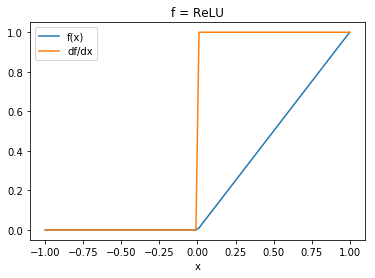

In [2]:
def relu(X):
    """ ReLU activation function """
    return np.where(X > 0, X, 0)

def d_relu(X):
    """ Derivative of the ReLU activation function """
    return np.where(X > 0, 1, 0)

# Let's visualize the actions of these functions
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-1, 1, num=100)
plt.plot(x, relu(x), label='f(x)')
plt.plot(x, d_relu(x), label='df/dx')
plt.title('f = ReLU')
plt.xlabel('x')
plt.legend();

We will define an API for the model that accepts arrays of integer labels for each sample. However, to keep compatibility with our equations, we will internaly make use of one hot vectors for some operations. The following function does this transformation.

In [3]:
def one_hot_convert(t, n_classes):
    """ Convert arrays of integer labels to one-hot encoded vectors.
    Args:
        - t (n,): array containing n labels
        - n_classes (int): the number of possible classes
    Returns: (n_classes, n) binary array containing one-hot
        vectors in its columns.
    """
    if np.min(t) < 0 or np.max(t) >= n_classes:
        raise ValueError("Elements in array must be in the interval [0, {:d})".format(n_classes))
    T = np.zeros((n_classes, len(t)), dtype=int)
    T[t, np.arange(len(t))] = 1
    return T

Next, we define the `NNClassifier` class, which contains methods to initialize the architecture, and methods for forward and backward passes as derived above. For convenience, I've defined different forward passes, which can be used for different situations:

- `NNClassifier.forward` performs a forward pass up to but not including the softmax. These values are not probabilities, as they are merely the result of the linear operation in the last layer. They are also known as the *logits*. When we want to pick the most likely class given an input, it is enough to get the index of the maximum logit, avoiding the calculation of probabilities.
- `NNClassifier.forward_probs` performs a complete forward pass, including the last softmax layer. This results in actual probabilities in the range $[0, 1]$.

As we saw during the derivations, the gradients with respect to the parameters of the layer require information of the input and output of the layer. This means that when doing a forward pass, this information needs to be stored if a backward pass is required later. The `forward` function has a `cache` argument that determines this. The `loss` function computes the loss given input vectors `X` and targets `t`, by calling `forward` with `cache=True` and saving also the gradient $\partial\mathcal{L}/\partial\mathbf{Z}_L$, so that all the information is ready to perform a backward pass to calculate all the gradients. Using this API, an example to calculate the gradients for a given input would go as follows:

```python
# Instantiate a model
model = NNClassifier(units)
# Get the loss with a forward pass
# (this also stores intermediate values needed for backpropagation)
loss = model.loss(X, t)
# Calculate the gradients with backpropagation
model.backward()
```

The class is defined below.

In [4]:
class NNClassifier:
    """ A neural network classifier.
    Args:
        - units (iterable): contains the number of units (int)
            for each layer, from the input layer up to the
            output layer.
    """
    def __init__(self, units):
        self.units = units
        self.n_classes = units[-1]
        self.layers = []
        for i in range(1, len(units)):
            self.layers.append(Linear(units[i - 1], units[i]))
        self.dZL = None
            
    def forward(self, X, cache=False):
        A_prev = X
        for layer in self.layers:
            Zl = layer(A_prev, cache)
            A_prev = relu(Zl)
        
        return Zl
    
    def _log_normalizer(self, ZL):
        max_ZL = np.max(ZL, axis=0, keepdims=True)
        log_Z = max_ZL + np.log(np.sum(np.exp(ZL - max_ZL), axis=0, keepdims=True))
        return log_Z
        
    def loss(self, X, t):
        ZL = self.forward(X, cache=True)
        log_Z = self._log_normalizer(ZL)
        log_probs = ZL - log_Z
        
        T = one_hot_convert(t, self.n_classes)
        Z = np.exp(log_Z)
        self.dZL = np.exp(ZL)/Z - T

        return -np.mean(log_probs[T == 1])
    
    def forward_probs(self, X):
        ZL = self.forward(X)
        log_Z = self._log_normalizer(ZL)
        log_probs = ZL - log_Z
        return np.exp(log_probs)
    
    def backward(self):
        # Number of samples in mini-batch
        n = self.dZL.shape[1]
        for i, layer in enumerate(reversed(self.layers)):
            if i == 0:
                dZl = self.dZL
            else:                
                dZl = d_relu(layer.Zl) * dAl
            layer.dW = 1/n * (dZl @ layer.A_prev.T)
            layer.db = np.mean(dZl, axis=1, keepdims=True)
            dAl = layer.W.T @ dZl

Lastly, we implement Stochastic Gradient Descent (SGD) to optimize the parameters of the network.

In [5]:
class SGD:
    """ Stochastic Gradient Descent optimizer.
    Args:
        - model (NNClassifier): model with parameters to optimize
        - lr (float): learning rate
    """
    def __init__(self, model, lr):
        self.lr = lr
        self.model = model
        
    def step(self):
        for layer in self.model.layers:
            layer.W = layer.W - self.lr * layer.dW
            layer.b = layer.b - self.lr * layer.db

## Testing the implementation

Given the rather general implementation, we are free to create different architectures. If we let the input vector to be one dimensional and build a binary classifier with no hidden layers, we end up with a Logistic Regression model. We thus should expect the model to be able to model the sigmoid function. Let us test this first.

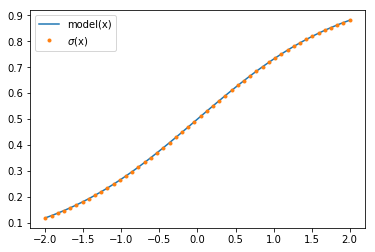

In [6]:
import matplotlib.pyplot as plt
from scipy.special import expit # i.e. sigmoid function
%matplotlib inline

# Define a binary classifier over a one-dimensional variable:
# 1 input unit, 2 output units, no hidden layers
model = NNClassifier([1, 2])
# Set the weights so that the model outputs the sigmoid
model.layers[0].W = np.array([[1], [0]])

# Visualize for different values of the input
x = np.linspace(-2, 2).reshape((1, -1))
y = model.forward_probs(x)
plt.plot(x.T, y[0, :], label='model(x)')
plt.plot(x.T, expit(x.T), '.', label=r'$\sigma$(x)')
plt.legend();

As we can see, the network can model the sigmoid function. For bigger networks, we can check that the output probabilities sum to one.

In [7]:
# Define an arbitrary network
inputs = 500
outputs = 10
model = NNClassifier([inputs, 100, 50, 40, outputs])

# Define data
n_samples = 1
X = np.random.rand(inputs, n_samples)

# Sum output probabilities
print(np.sum(model.forward_probs(X)))

1.0000000000000002


Close enough!

There is one last and very important test that we need, which concerns the implementation of backpropagation. If it is correct, all the gradients of the loss with respect to the parameters could be approximated up to a small error using a finite difference approximation. To check this we can use scipy's `check_grad` function, which according to the documentation, returns

> The square root of the sum of squares (i.e. the 2-norm) of the difference between grad(...) and the finite difference approximation of grad.

We will use this function to print the sum of squares for each layer, for each parameter (weights and bias) in the network.

In [8]:
from scipy.optimize import check_grad

# Create some random targets to evaluate the loss
t = np.random.randint(0, high=outputs, size=(1, n_samples))

for l, layer in enumerate(model.layers):
    print('Layer {:d}'.format(l + 1))
    for param in ['W', 'b']:
        def func(x):
            # Set the parameter and evaluate the loss
            setattr(layer, param, np.reshape(x, getattr(layer, param).shape))
            return model.loss(X, t)

        def grad(x):
            # Set the parameter and evaluate the gradient
            setattr(layer, param, np.reshape(x, getattr(layer, param).shape))
            model.loss(X, t)
            model.backward()
            return np.ravel(getattr(layer, 'd' + param))

        #x = np.ravel(getattr(layer, param))
        #print('d{}: {}'.format(param, check_grad(func, grad, x)))

Layer 1
Layer 2
Layer 3
Layer 4


We can deem these low enough to trust the implementation of backpropagation. We can proceed to train the model with some toy data, just to see if the model is able to overfit to it.

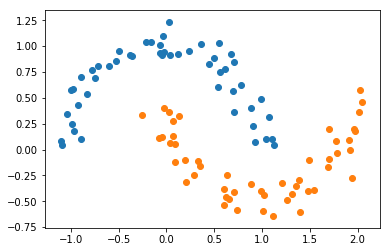

In [9]:
from sklearn.datasets import make_moons

X, Y = make_moons(noise=0.1)
plt.scatter(X[Y==0, 0], X[Y==0, 1])
plt.scatter(X[Y==1, 0], X[Y==1, 1]);

A linear model with no hidden units would not perform well since the classes are not linearly separable. We will train a model with one hidden layer, with 10 units in it.

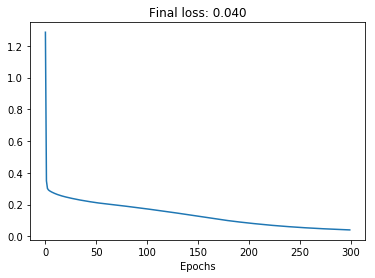

In [10]:
model = NNClassifier([2, 10, 2])
optimizer = SGD(model, lr=0.5)

n_epochs = 300
loss_history = np.zeros(n_epochs)

for epoch in range(n_epochs):
    # Forward pass
    loss_history[epoch] = model.loss(X.T, Y)
    # Backward pass
    model.backward()
    # Parameter updates
    optimizer.step()

plt.plot(loss_history)
plt.title('Final loss: {:.3f}'.format(np.min(loss_history)))
plt.xlabel('Epochs');

The optimizer seems to be doing its job! The loss decreases monotonically and gets to a low value, confirming that we can overfit to the training data. As in a [previous post](https://dfdazac.github.io/04-fisher-example.html), we can visualize the decision boundary created by the model after training:

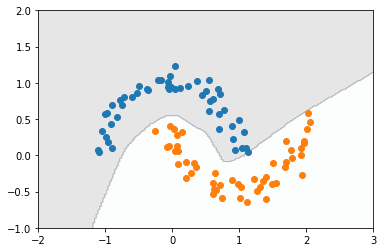

In [11]:
# Create a grid
N = 200
x1 = np.linspace(-2, 3, N)
x2 = np.linspace(-1, 2, N)
X1, X2 = np.meshgrid(x1, x2)
X_flat = np.column_stack((X1.flatten(), X2.flatten()))

# Evaluate model on grid
Y_pred = model.forward_probs(X_flat.T)[0, :].reshape(X1.shape) < 0.5

plt.contourf(X1, X2, Y_pred, cmap='bone', alpha=0.1)
plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1]);

It's interesting to see how this decision boundary is much more irregular compared to that obtained by Fisher's discriminant in the previous post. The neural network is a more complex model, so it can come up with more elaborate functions of the input, as we observe here.

As we have seen, the implementation from scratch can be challenging but also very rewarding. Knowing how a neural network works and is trained can be useful when debugging problems such as overfitting and exploding and vanishing gradients. On the other hand, we are lucky to have tools such as automatic differentiation, which enables us to apply backpropagation to bigger and more complex models easily.

In future posts I hope to use the implementation we've seen here in problems such as the classic MNIST dataset, and important aspects such as improved gradient descent algorithmgs, regularization techniques and hyperameter tuning.

**References**

[1] He, Kaiming, et al. "Delving deep into rectifiers: Surpassing human-level performance on imagenet classification." *Proceedings of the IEEE international conference on computer vision*. 2015.

---

<a name="1">1</a>. But why this "softmax"? For binary classification problems we use the *logistic sigmoid*, and the fact that these functions are used is related to a class of models known as Generalized Linear Models. When working with binary classification problems, we are trying to model a Bernoulli distribution, for which we can find what is known as a *link function* from which the sigmoid can be derived. Similarly, the softmax corresponds to the Categorical distribution. [This](http://blog.shakirm.com/2015/01/a-statistical-view-of-deep-learning-i-recursive-glms/) is an interesting discussion that frames neural networks as hierarchical generalized linear models.<sup>[^](#1b)</sup>

<a name="2">2</a>. In practice we don't necessarily want to find the minimum for this objective. We could minimize it as much as we can by choosing an appropriately complex model and training for long enough, but we might end up overfitting to the training set and with a model that does not generalize well to unseen data. In the end, we want our model to perform well both on training and test data, and with neural networks there are multiple ways to achieve this, such as weight regularization, dropout, data augmentation, among other techniques. <sup>[^](#2b)</sup>